In [1]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
import tfim_1d
import quspin
import fejer_kernel
import fourier_filter
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

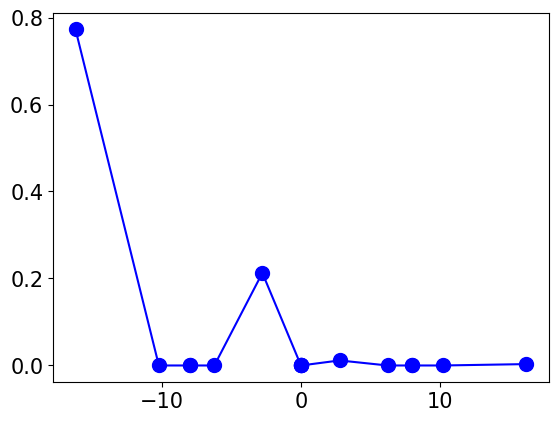

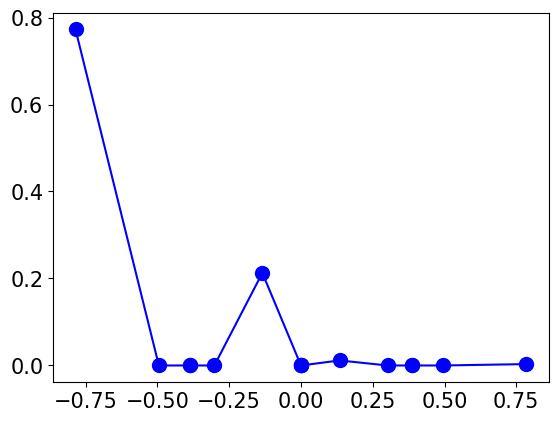

In [2]:
from scipy.linalg import norm
from scipy.linalg import expm
from numpy.linalg import eigh
from scipy.linalg import eigh

def modify_spectrum(ham):
    arr_ham = ham.toarray()
    arr_ham = arr_ham.astype(np.complex128)
    n = len(arr_ham[0])
    eigenenergies, eigenstates = ham.eigh(subset_by_index = (n-1,n-1))
    max_eigenvalue = eigenenergies[0]
    norm_ham = (np.pi/4)*arr_ham/max_eigenvalue
    # rotate matrix so that it will be positive definite
    # ham += 1/2*np.eye(2**eigen_bits)
    
    # convert revolutions to radians
    # norm_ham *= 2*np.pi*1j
    
    # convert the rotations to complex numbers
    # norm_ham = expm(norm_ham)
    return norm_ham

num_sites = 4
J = 1.0
g = 4.0

num_eigenstates_max = 100

ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

# plot original spectrum
ham = tfim_1d.generate_ham(num_sites, J, g)
eigenenergies, eigenstates = ham.eigh()
ground_state = eigenstates[:,0]
population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population_raw, 'b-o')
plt.show()

# create modified spectrum
ham = modify_spectrum(ham)
eigenenergies, eigenstates = eigh(ham)
ground_state = eigenstates[:,0]
population = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population, 'b-o')
plt.show()

In [3]:
p0_array            = np.array([0.6,0.8]) # initial overlap with the first eigenvector
T0                  = 100
N_test_QCELS        = 10 # number of different circuit depths for QCELS test
N_QPE               = 10 # number of different circuit depths for QCELS QPE test
T_list_QCELS        = 10+T0/2*(np.arange(N_test_QCELS)) # circuit depth for QCELS
T_list_QPE          = 10+T0*4*(np.arange(N_QPE)) # circuit depth for QPE
err_QCELS           = np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE             = np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE   = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS  = np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE    = np.zeros((len(p0_array),len(T_list_QPE)))
max_T_QCELS         = np.zeros((len(p0_array),len(T_list_QCELS)))
Navg                = 2 # number of trials
err_thres_hold      = 0.01
err_thres_hold_QPE  = 0.01  

In [4]:
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    n_success_QCELS= np.zeros(len(T_list_QCELS))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0])
        #------------------QCELS-----------------
        Nsample=100 #number of samples for constructing the loss function
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            NT = 5
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cost_list_QCELS_this, max_T_QCELS_this = \
                    qcels_largeoverlap(spectrum, population, T, NT,
                            Nsample, lambda_prior)#QCELS with time T
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - spectrum[0])
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cost_list_QCELS_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1

       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi 
            dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
            j_min = samp.min()
            ground_energy_estimate_QPE = discrete_energies[j_min]
            err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
            if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg
np.savez('Data/Lin_Sim_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('Data/Lin_Sim_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('Data/Lin_Sim_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

For p0= 0.6 For N_test= 1
START QCELS
Re:  1.0 Im:  0.44
		 (1-0.12j)
Re:  0.9 Im:  0.78
		 (0.8+0.56j)
Re:  0.66 Im:  0.8
		 (0.32000000000000006+0.6000000000000001j)
Re:  0.53 Im:  0.8
		 (0.06000000000000005+0.6000000000000001j)
Re:  0.42 Im:  0.59
		 (-0.16000000000000003+0.17999999999999994j)
	 [ 0.697361   -0.03785117 -0.55624004]
Re:  1.0 Im:  0.39
		 (1-0.21999999999999997j)
Re:  0.78 Im:  0.85
		 (0.56+0.7j)
Re:  0.4 Im:  0.7
		 (-0.19999999999999996+0.3999999999999999j)
Re:  0.58 Im:  0.35
		 (0.15999999999999992-0.30000000000000004j)
Re:  0.89 Im:  0.67
		 (0.78+0.3400000000000001j)
	 [ 0.54419075 -0.34563189 -0.88686296]
END QCELS
START QCELS
Re:  1.0 Im:  0.48
		 (1-0.040000000000000036j)
Re:  0.83 Im:  0.84
		 (0.6599999999999999+0.6799999999999999j)
Re:  0.42 Im:  0.74
		 (-0.16000000000000003+0.48j)
Re:  0.36 Im:  0.54
		 (-0.28+0.08000000000000007j)
Re:  0.6 Im:  0.32
		 (0.19999999999999996-0.36j)
	 [ 0.57647779 -0.15731856 -0.81779635]
Re:  1.0 Im:  0.5
		 (1+0j)
Re:

In [5]:
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    n_success_QCELS= np.zeros(len(T_list_QCELS))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0])
        #------------------QCELS-----------------
        Nsample=100 #number of samples for constructing the loss function
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            NT = 5
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cost_list_QCELS_this, max_T_QCELS_this = \
                    qcels_largeoverlap_ham(ham, T, NT, Nsample, lambda_prior)
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - lambda_prior)
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cost_list_QCELS_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1

       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi 
            dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
            j_min = samp.min()
            ground_energy_estimate_QPE = discrete_energies[j_min]
            err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
            if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg
np.savez('Data/Q_Sim_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('Data/Q_Sim_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('Data/Q_Sim_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

For p0= 0.6 For N_test= 1
START QCELS
Re:  1.0 Im:  0.52
		 (1+0j)
Re:  0.86 Im:  0.85
		 (0.72+0.6939740629158989j)
Re:  0.53 Im:  0.99
		 (0.06000000000000001+0.9981983770774224j)
Re:  0.16 Im:  0.84
		 (-0.6799999999999998+0.7332121111929345j)
Re:  0 Im:  0.45
		 (-1+1.2246467991473532e-16j)
	 [ 0.99956425 -0.01865644 -0.78321614]
Re:  1.0 Im:  0.56
		 (1+0j)
Re:  0.56 Im:  0.97
		 (0.1200000000000002+0.9927738916792685j)
Re:  0.02 Im:  0.44
		 (-0.96-0.2800000000000001j)
Re:  0.47 Im:  0.02
		 (-0.060000000000000796-0.9981983770774224j)
Re:  1.0 Im:  0.5
		 (1+0j)
	 [ 0.99023768  0.00753865 -0.78849865]
END QCELS
START QCELS
Re:  1.0 Im:  0.53
		 (1+0j)
Re:  0.64 Im:  0.91
		 (0.28+0.96j)
Re:  0.15 Im:  0.79
		 (-0.6999999999999998+0.7141428428542852j)
Re:  0.05 Im:  0.37
		 (-0.9000000000000001-0.43588989435406716j)
Re:  0.55 Im:  0.01
		 (0.09999999999999977-0.99498743710662j)
	 [ 0.998943    0.02119336 -0.79535759]
Re:  1.0 Im:  0.46
		 (1-2.4492935982947064e-16j)
Re:  0.24 Im: 